# **Please run this notebook in google colab. Save this notebook into your google drive and open it in colab.  Mount your drive. Download the dataset from [here](https://drive.google.com/drive/folders/1gdAQ7ugDS89-aZufli--nhvn-DDLlULW?usp=sharing) and upload in your drive. Run this notebook cell by cell. Note - This model is run on CMAPPS FD002 dataset using the hyperparameters obtained by running hyperparameter optimization.**

Your runtime will restart automatically after running this cell. 
Note - Run this cell once that all the libraries needed are installed. After runtime is restarted, start running from the next cell.

In [1]:
!pip3 install pyunpack wget patool plotly cufflinks --user tensorflow==1.15

# Resets the IPython kernel to import the installed package.
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 412.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 43.7MB/s 
     |████████████████████████████████| 512kB 56.0MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=b8f33627007328a9b4f270318a1f1ad7293705573a93f8b8c14643408a80dc1e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=dc7da9980a664d6936ffcf3dac21bf368674052883d58a27d61e854a8e9f916e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built wget gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this

{'restart': True, 'status': 'ok'}

### Importing the necessary libraries and packages

In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import gc
import json
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib import gridspec
from google.colab import files
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
import abc
import enum
import datetime, os
import pathlib
%matplotlib inline

# Creating folders to store outputs and saved models temporarily in storage.

In [2]:
output_folder = os.path.join(os.getcwd(), 'outputs')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
path = os.path.join(output_folder,'results','CMAPPS')
if not os.path.exists(path):
    os.makedirs(path)
path = os.path.join(output_folder,'saved_models','CMAPPS')
if not os.path.exists(path):
    os.makedirs(path)

# Loading the dataset FD002 and pre-processing to make it ready for data exploration and learning.

In [3]:
RUL=pd.read_csv('/content/drive/MyDrive/CMAPPS_data/RUL_FD002.txt',sep=" ",header=None)
RUL.drop(RUL.columns[1], axis = 1, inplace = True)
RUL

0
0     18
1     79
2    106
3    110
4     15
..   ...
254  122
255  191
256   56
257  131
258   51

[259 rows x 1 columns]

In [4]:
df_train=pd.read_csv('/content/drive/MyDrive/CMAPPS_data/train_FD002.txt',sep=" ",header=None)
columns_name=['ID','Cycles','Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21','Sensor22','Sensor23']
df_train.columns=columns_name
plot1=df_train.groupby(by=['ID'])[['Cycles']].max()
plot1=plot1.reset_index()
df_train=pd.merge(left=df_train,right=plot1,left_on='ID',right_on='ID',how='left',indicator=False)
df_train['RUL']=df_train.Cycles_y-df_train.Cycles_x
df_train=df_train.drop(columns=['Cycles_y', 'Sensor22','Sensor23'])
columns_name=['ID','cycle','Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21','RUL']
df_train.columns=columns_name
df_train['categorical_ID']=df_train['ID']
df_train

ID  cycle  Setting1  Setting2  ...  Sensor20  Sensor21  RUL  categorical_ID
0        1      1   34.9983    0.8400  ...     14.73    8.8071  148               1
1        1      2   41.9982    0.8408  ...     10.41    6.2665  147               1
2        1      3   24.9988    0.6218  ...     14.08    8.6723  146               1
3        1      4   42.0077    0.8416  ...     10.59    6.4701  145               1
4        1      5   25.0005    0.6203  ...     14.13    8.5286  144               1
...    ...    ...       ...       ...  ...       ...       ...  ...             ...
53754  260    312   20.0037    0.7000  ...     24.36   14.5189    4             260
53755  260    313   10.0022    0.2510  ...     28.10   16.9454    3             260
53756  260    314   25.0041    0.6200  ...     14.19    8.5503    2             260
53757  260    315   25.0033    0.6220  ...     14.05    8.3729    1             260
53758  260    316   35.0036    0.8400  ...     14.75    8.8446    0             260

[53759 rows x 28 columns]

In [5]:
df_test=pd.read_csv('/content/drive/MyDrive/CMAPPS_data/test_FD002.txt',sep=" ",header=None)
columns_name=['ID','Cycles','Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21','Sensor22','Sensor23']
df_test.columns=columns_name
plot1=df_test.groupby(by=['ID'])[['Cycles']].max()
plot1=plot1.reset_index()
df_test=pd.merge(left=df_test,right=plot1,left_on='ID',right_on='ID',how='left',indicator=False)
df_test['RUL']=df_test.Cycles_y-df_test.Cycles_x
df_test=df_test.drop(columns=['Cycles_y','Sensor22','Sensor23'])
columns_name=['ID','cycle','Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21','RUL']
df_test.columns=columns_name
df_test['categorical_ID'] = df_test['ID']
for n in np.unique(df_test['ID']):
  df_test.loc[df_test['ID']==n,['RUL']] = df_test.loc[df_test['ID']==n,['RUL']] + RUL.iloc[n-1,0]
df_test

ID  cycle  Setting1  Setting2  ...  Sensor20  Sensor21  RUL  categorical_ID
0        1      1    9.9987    0.2502  ...     28.42   17.1551  275               1
1        1      2   20.0026    0.7000  ...     24.29   14.8039  274               1
2        1      3   35.0045    0.8400  ...     14.98    8.9125  273               1
3        1      4   42.0066    0.8410  ...     10.35    6.4181  272               1
4        1      5   24.9985    0.6213  ...     14.31    8.5740  271               1
...    ...    ...       ...       ...  ...       ...       ...  ...             ...
33986  259    119   35.0015    0.8403  ...     14.94    8.9065   55             259
33987  259    120   42.0066    0.8405  ...     10.57    6.4075   54             259
33988  259    121   42.0061    0.8400  ...     10.57    6.4805   53             259
33989  259    122    0.0024    0.0003  ...     39.08   23.3589   52             259
33990  259    123   42.0033    0.8400  ...     10.63    6.3480   51             259

[33991 rows x 28 columns]

In [6]:
df_valid = df_test[df_test['ID'].isin(list(range(1,200)))]
df_valid

ID  cycle  Setting1  Setting2  ...  Sensor20  Sensor21  RUL  categorical_ID
0        1      1    9.9987    0.2502  ...     28.42   17.1551  275               1
1        1      2   20.0026    0.7000  ...     24.29   14.8039  274               1
2        1      3   35.0045    0.8400  ...     14.98    8.9125  273               1
3        1      4   42.0066    0.8410  ...     10.35    6.4181  272               1
4        1      5   24.9985    0.6213  ...     14.31    8.5740  271               1
...    ...    ...       ...       ...  ...       ...       ...  ...             ...
26871  199    113    0.0028    0.0007  ...     38.91   23.3282  107             199
26872  199    114   10.0054    0.2513  ...     28.49   17.2282  106             199
26873  199    115   20.0001    0.7000  ...     24.70   14.6619  105             199
26874  199    116   42.0047    0.8401  ...     10.79    6.3805  104             199
26875  199    117    0.0003    0.0000  ...     39.16   23.4414  103             199

[26876 rows x 28 columns]

# Exploratory Analysis

In [7]:
plot1=df_train.groupby(by=['ID'])[['cycle']].max()
plot1=plot1.reset_index()
plt.figure()
plot1.plot(kind='barh',x='ID',y='cycle',width=0.8, stacked=True,align='center',rot=0,figsize=(70,150))
plt.title("Train data : Engine Life",size=70)
plt.xlabel('Number of Cycles',size=70)
plt.xticks(size=70)
plt.ylabel('ID Number',size=70)
plt.yticks(size=40)
plt.grid(True)
plt.tight_layout(True)
plt.show()
#plt.savefig('exp_train.png',dpi=100)
#files.download("exp_train.png")

<Figure size 432x288 with 0 Axes>

In [8]:
plot1=df_test.groupby(by=['ID'])[['cycle']].max()
plot1=plot1.reset_index()
plt.figure()
plot1.plot(kind='barh',x='ID',y='cycle',width=0.8, stacked=True,align='center',rot=0,figsize=(70,150))
plt.title("Train data : Engine Life",size=70)
plt.xlabel('Number of Cycles',size=70)
plt.xticks(size=70)
plt.ylabel('ID Number',size=70)
plt.yticks(size=40)
plt.grid(True)
plt.tight_layout(True)
plt.show()

<Figure size 432x288 with 0 Axes>

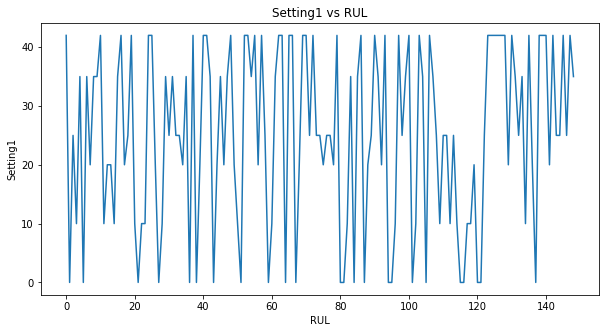

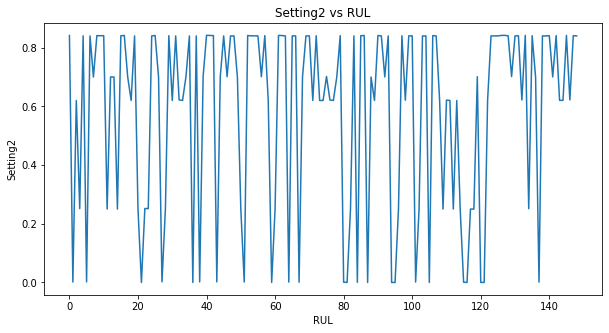

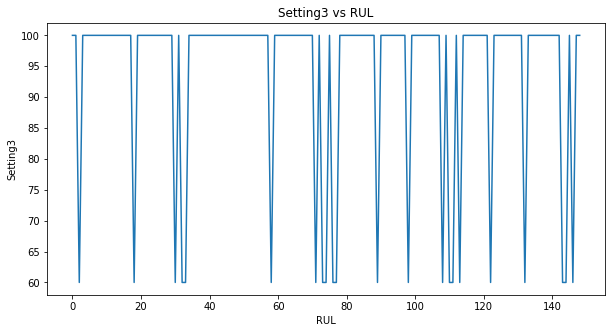

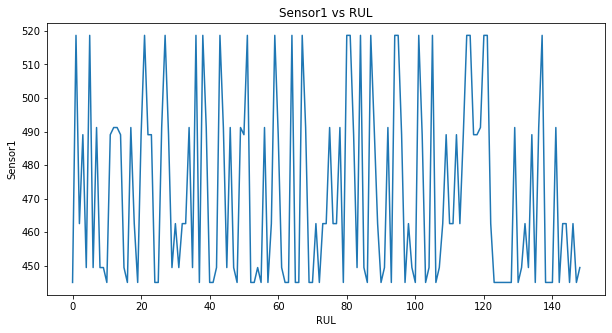

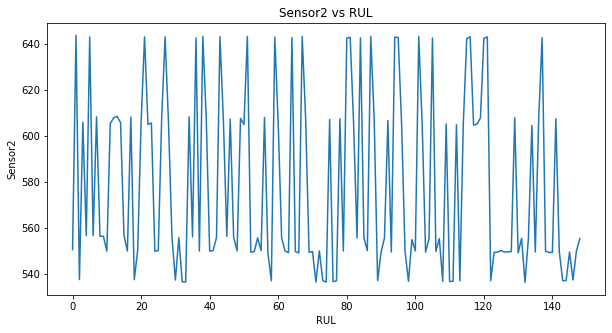

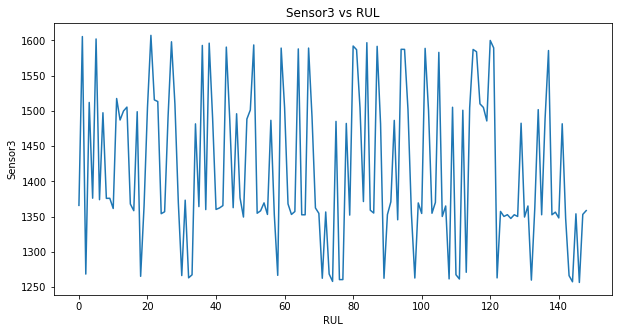

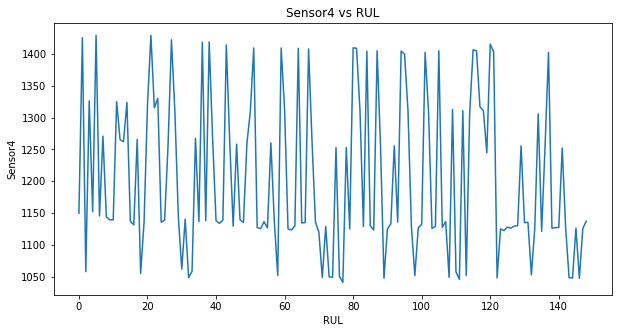

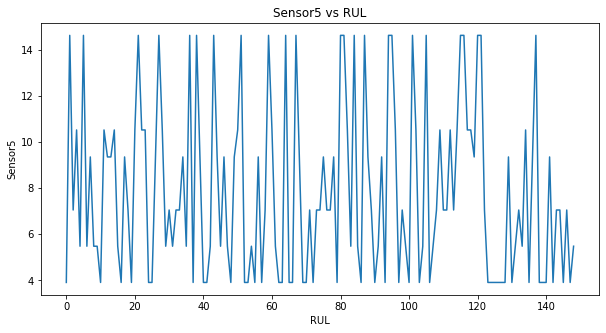

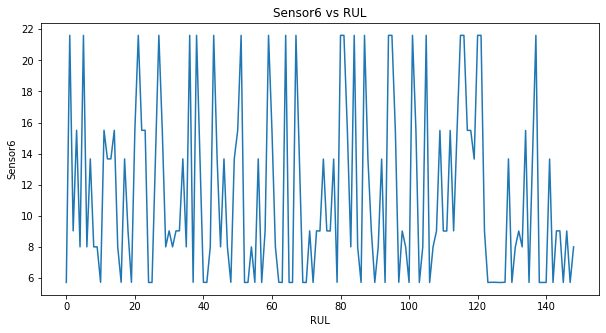

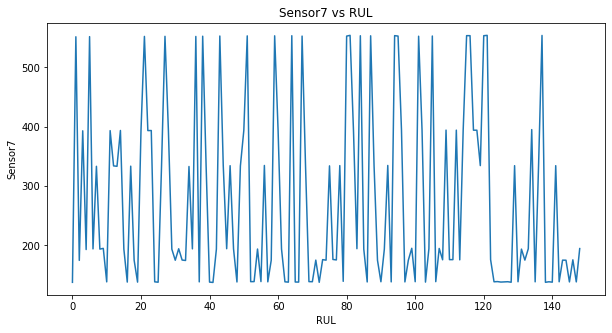

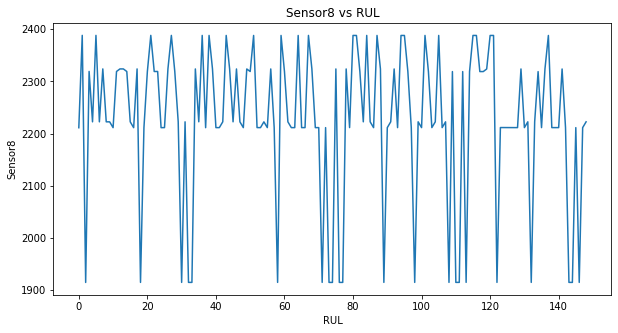

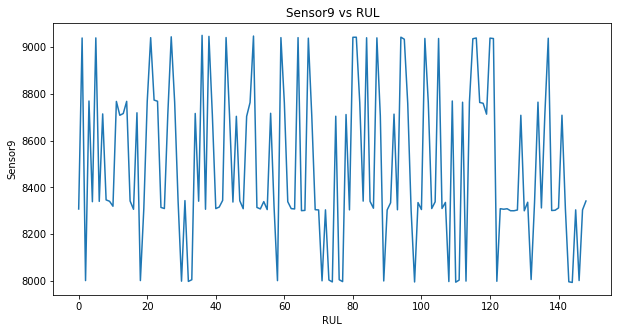

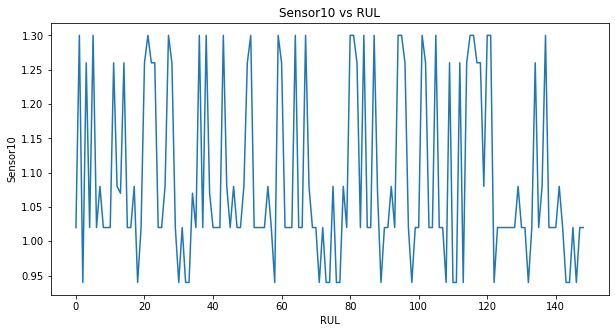

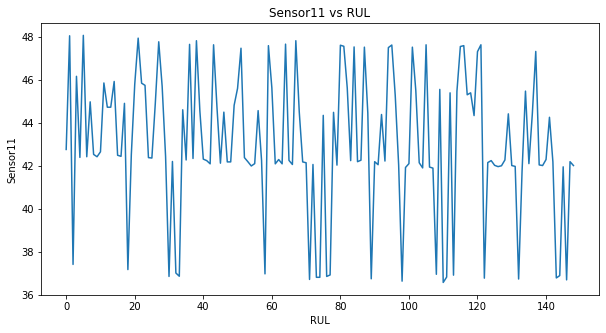

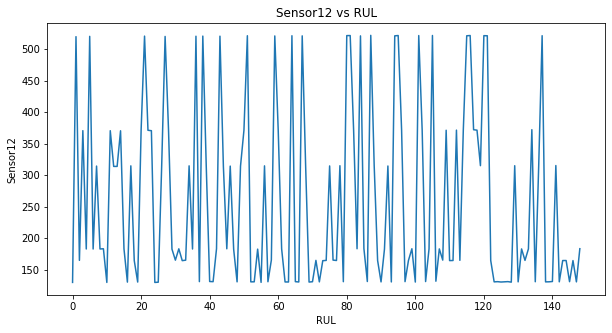

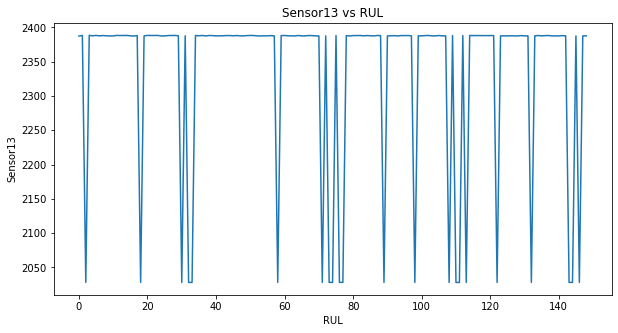

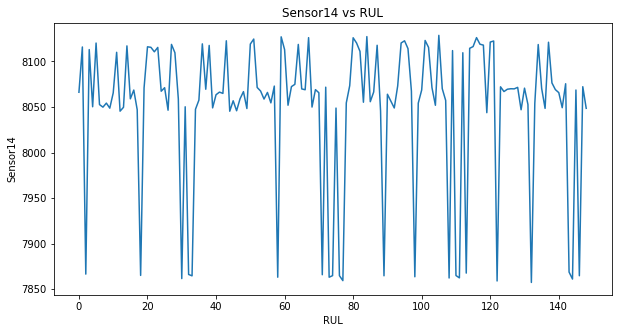

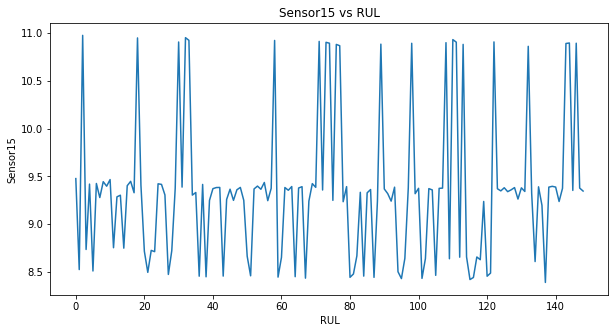

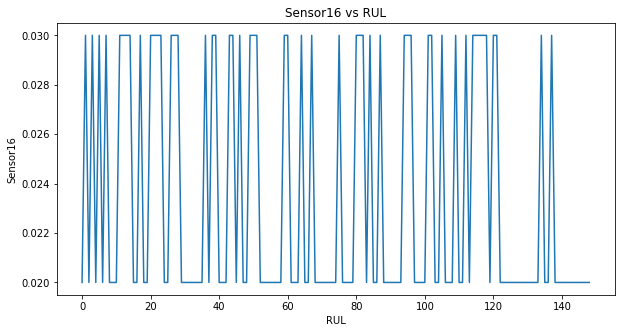

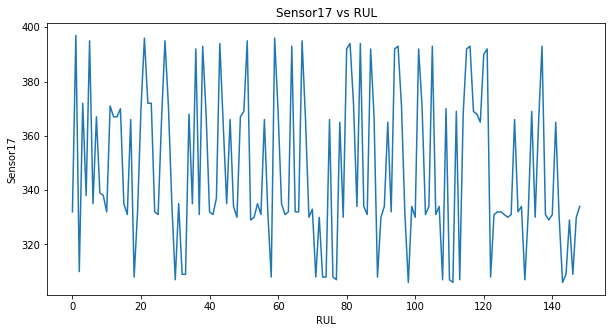

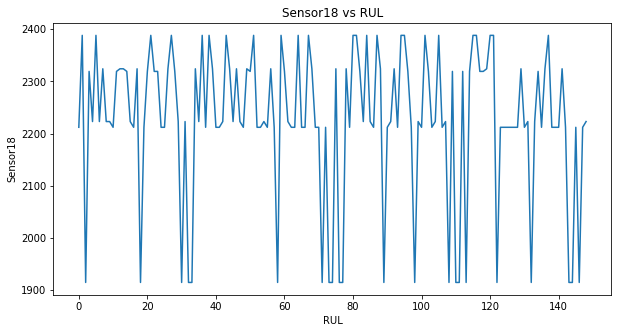

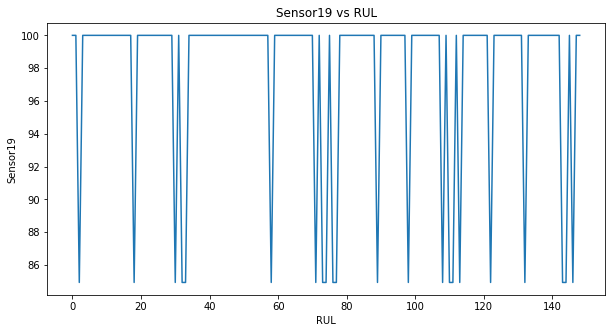

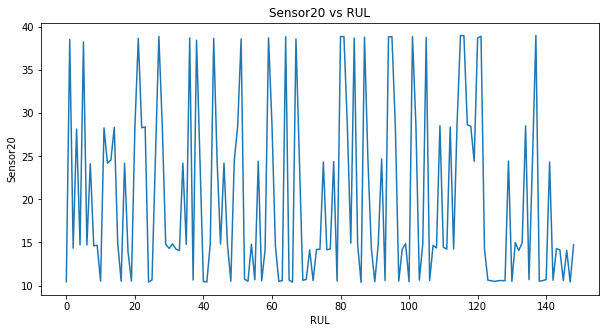

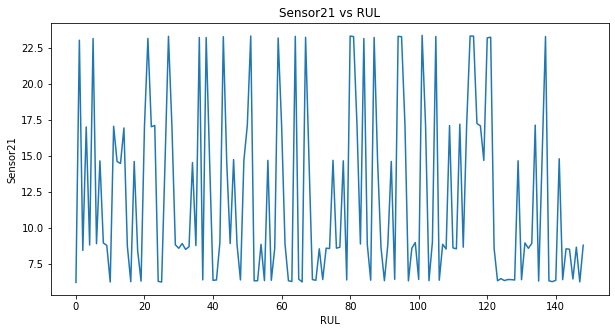

In [9]:
def pltu(x):
    plt.figure(figsize=(10,5))
    plt.plot(df_train[df_train['ID']==1]['RUL'],df_train[df_train['ID']==1][x])
    plt.ylabel(x)
    plt.xlabel('RUL')
    plt.title(x +' vs RUL')
    plt.show()
    
for i in ['Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21']:
    pltu(i)

# Data Formatting Code

In [10]:

"""Default data formatting functions for experiments.

For new datasets, inherit form GenericDataFormatter and implement
all abstract functions.

These dataset-specific methods:
1) Define the column and input types for tabular dataframes used by model
2) Perform the necessary input feature engineering & normalisation steps
3) Reverts the normalisation for predictions
4) Are responsible for train, validation and test splits


"""

import abc
import enum


# Type defintions
class DataTypes(enum.IntEnum):
  """Defines numerical types of each column."""
  REAL_VALUED = 0
  CATEGORICAL = 1
  DATE = 2


class InputTypes(enum.IntEnum):
  """Defines input types of each column."""
  TARGET = 0
  OBSERVED_INPUT = 1
  KNOWN_INPUT = 2
  STATIC_INPUT = 3
  ID = 4  # Single column used as an entity identifier
  TIME = 5  # Single column exclusively used as a time index


class GenericDataFormatter(abc.ABC):
  """Abstract base class for all data formatters.

  User can implement the abstract methods below to perform dataset-specific
  manipulations.

  """

  @abc.abstractmethod
  def set_scalers(self, df):
    """Calibrates scalers using the data supplied."""
    raise NotImplementedError()

  @abc.abstractmethod
  def transform_inputs(self, df):
    """Performs feature transformation."""
    raise NotImplementedError()

  @abc.abstractmethod
  def format_predictions(self, df):
    """Reverts any normalisation to give predictions in original scale."""
    raise NotImplementedError()

  @abc.abstractmethod
  def split_data(self, df):
    """Performs the default train, validation and test splits."""
    raise NotImplementedError()

  @property
  @abc.abstractmethod
  def _column_definition(self):
    """Defines order, input type and data type of each column."""
    raise NotImplementedError()

  @abc.abstractmethod
  def get_fixed_params(self):
    """Defines the fixed parameters used by the model for training.

    Requires the following keys:
      'total_time_steps': Defines the total number of time steps used by TFT
      'num_encoder_steps': Determines length of LSTM encoder (i.e. history)
      'num_epochs': Maximum number of epochs for training
      'early_stopping_patience': Early stopping param for keras
      'multiprocessing_workers': # of cpus for data processing


    Returns:
      A dictionary of fixed parameters, e.g.:

      fixed_params = {
          'total_time_steps': 252 + 5,
          'num_encoder_steps': 252,
          'num_epochs': 100,
          'early_stopping_patience': 5,
          'multiprocessing_workers': 5,
      }
    """
    raise NotImplementedError

  # Shared functions across data-formatters
  @property
  def num_classes_per_cat_input(self):
    """Returns number of categories per relevant input.

    This is seqeuently required for keras embedding layers.
    """
    return self._num_classes_per_cat_input

  def get_num_samples_for_calibration(self):
    """Gets the default number of training and validation samples.

    Use to sub-sample the data for network calibration and a value of -1 uses
    all available samples.

    Returns:
      Tuple of (training samples, validation samples)
    """
    return -1, -1

  def get_column_definition(self):
    """"Returns formatted column definition in order expected by the TFT."""

    column_definition = self._column_definition

    # Sanity checks first.
    # Ensure only one ID and time column exist
    def _check_single_column(input_type):

      length = len([tup for tup in column_definition if tup[2] == input_type])

      if length != 1:
        raise ValueError('Illegal number of inputs ({}) of type {}'.format(
            length, input_type))

    _check_single_column(InputTypes.ID)
    _check_single_column(InputTypes.TIME)

    identifier = [tup for tup in column_definition if tup[2] == InputTypes.ID]
    time = [tup for tup in column_definition if tup[2] == InputTypes.TIME]
    real_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.REAL_VALUED and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]
    categorical_inputs = [
        tup for tup in column_definition if tup[1] == DataTypes.CATEGORICAL and
        tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    return identifier + time + real_inputs + categorical_inputs

  def _get_input_columns(self):
    """Returns names of all input columns."""
    return [
        tup[0]
        for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

  def _get_tft_input_indices(self):
    """Returns the relevant indexes and input sizes required by TFT."""

    # Functions
    def _extract_tuples_from_data_type(data_type, defn):
      return [
          tup for tup in defn if tup[1] == data_type and
          tup[2] not in {InputTypes.ID, InputTypes.TIME}
      ]

    def _get_locations(input_types, defn):
      return [i for i, tup in enumerate(defn) if tup[2] in input_types]

    # Start extraction
    column_definition = [
        tup for tup in self.get_column_definition()
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    categorical_inputs = _extract_tuples_from_data_type(DataTypes.CATEGORICAL,
                                                        column_definition)
    real_inputs = _extract_tuples_from_data_type(DataTypes.REAL_VALUED,
                                                 column_definition)

    locations = {
        'input_size':
            len(self._get_input_columns()),
        'output_size':
            len(_get_locations({InputTypes.TARGET}, column_definition)),
        'category_counts':
            self.num_classes_per_cat_input,
        'input_obs_loc':
            _get_locations({InputTypes.TARGET}, column_definition),
        'static_input_loc':
            _get_locations({InputTypes.STATIC_INPUT}, column_definition),
        'known_regular_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           real_inputs),
        'known_categorical_inputs':
            _get_locations({InputTypes.STATIC_INPUT, InputTypes.KNOWN_INPUT},
                           categorical_inputs),
    }

    return locations

  def get_experiment_params(self):
    """Returns fixed model parameters for experiments."""

    required_keys = [
        'total_time_steps', 'num_encoder_steps', 'num_epochs',
        'early_stopping_patience', 'multiprocessing_workers'
    ]

    fixed_params = self.get_fixed_params()

    for k in required_keys:
      if k not in fixed_params:
        raise ValueError('Field {}'.format(k) +
                         ' missing from fixed parameter definitions!')

    fixed_params['column_definition'] = self.get_column_definition()

    fixed_params.update(self._get_tft_input_indices())
    fixed_params.update(self.get_default_model_params())
    fixed_params['model_folder'] = os.path.join(output_folder, 'saved_models', 'CMAPPS')
    return fixed_params


In [11]:
#Load TFT helper functions

def get_single_col_by_input_type(input_type, column_definition):
  """Returns name of single column.

  Args:
    input_type: Input type of column to extract
    column_definition: Column definition list for experiment
  """

  l = [tup[0] for tup in column_definition if tup[2] == input_type]

  if len(l) != 1:
    raise ValueError('Invalid number of columns for {}'.format(input_type))

  return l[0]


def extract_cols_from_data_type(data_type, column_definition,
                                excluded_input_types):
  """Extracts the names of columns that correspond to a define data_type.

  Args:
    data_type: DataType of columns to extract.
    column_definition: Column definition to use.
    excluded_input_types: Set of input types to exclude

  Returns:
    List of names for columns with data type specified.
  """
  return [
      tup[0]
      for tup in column_definition
      if tup[1] == data_type and tup[2] not in excluded_input_types
  ]      # Load TFT helper functions

def create_folder_if_not_exist(directory):
  """Creates folder if it doesn't exist.

  Args:
    directory: Folder path to create.
  """
  # Also creates directories recursively
  pathlib.Path(directory).mkdir(parents=True, exist_ok=True)

def tensorflow_quantile_loss(y, y_pred, quantile):
  """Computes quantile loss for tensorflow.

  Standard quantile loss as defined in the "Training Procedure" section of
  the main TFT paper

  Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)

  Returns:
    Tensor for quantile loss.
  """

  # Checks quantile
  if quantile < 0 or quantile > 1:
    raise ValueError(
        'Illegal quantile value={}! Values should be between 0 and 1.'.format(
            quantile))

  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

def save(tf_session, model_folder, cp_name, scope=None):
  """Saves Tensorflow graph to checkpoint.

  Saves all trainiable variables under a given variable scope to checkpoint.

  Args:
    tf_session: Session containing graph
    model_folder: Folder to save models
    cp_name: Name of Tensorflow checkpoint
    scope: Variable scope containing variables to save
  """
  # Save model
  if scope is None:
    saver = tf.train.Saver()
  else:
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
    saver = tf.train.Saver(var_list=var_list, max_to_keep=100000)

  save_path = saver.save(tf_session,
                         os.path.join(model_folder, '{0}.ckpt'.format(cp_name)))
  print('Model saved to: {0}'.format(save_path))

def load(tf_session, model_folder, cp_name, scope=None, verbose=False):
  """Loads Tensorflow graph from checkpoint.

  Args:
    tf_session: Session to load graph into
    model_folder: Folder containing serialised model
    cp_name: Name of Tensorflow checkpoint
    scope: Variable scope to use.
    verbose: Whether to print additional debugging information.
  """
  # Load model proper
  load_path = os.path.join(model_folder, '{0}.ckpt'.format(cp_name))

  print('Loading model from {0}'.format(load_path))

  print_weights_in_checkpoint(model_folder, cp_name)

  initial_vars = set(
      [v.name for v in tf.get_default_graph().as_graph_def().node])

  # Saver
  if scope is None:
    saver = tf.train.Saver()
  else:
    var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)
    saver = tf.train.Saver(var_list=var_list, max_to_keep=100000)
  # Load
  saver.restore(tf_session, load_path)
  all_vars = set([v.name for v in tf.get_default_graph().as_graph_def().node])

  if verbose:
    print('Restored {0}'.format(','.join(initial_vars.difference(all_vars))))
    print('Existing {0}'.format(','.join(all_vars.difference(initial_vars))))
    print('All {0}'.format(','.join(all_vars)))

  print('Done.')

In [12]:
import sklearn.preprocessing



# Implement formatting functions
class NCMAPPSFormatter(GenericDataFormatter):
    """Defines and formats data for the NCMAPPS dataset.
    Attributes:
    column_definition: Defines input and data type of column used in the
      experiment.
    identifiers: Entity identifiers used in experiments.
    """
   
    # This defines the types used by each column
    _column_definition = [
      ('ID', DataTypes.REAL_VALUED, InputTypes.ID),  
      ('cycle', DataTypes.REAL_VALUED, InputTypes.TIME),       ## Data  of time  type
      
      ('RUL', DataTypes.REAL_VALUED, InputTypes.TARGET),
      ('Sensor1', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor2', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor3', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor4', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor5', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor6', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor7', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor8', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor9', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor10', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor11', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor12', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor13', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor14', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor15', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor16', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor17', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor18', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor19', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor20', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('Sensor21', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
      ('cycle', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('Setting1', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('Setting2', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('Setting3', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
      ('categorical_ID', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT)
      
      
    ]

    def __init__(self):
      self.identifiers = None
      self._real_scalers = None
      self._cat_scalers = None
      self._target_scaler = None
      self._num_classes_per_cat_input = None
      self._time_steps = self.get_fixed_params()['total_time_steps']

    def split_data(self, df, valid_boundary=70, test_boundary=83):
        """Splits data frame into training-validation-test data frames.

        This also calibrates scaling object, and transforms data for each split.

        Args:
          df: Source data frame to split.
          valid_boundary: Starting year for validation data
          test_boundary: Starting year for test data

        Returns:
          Tuple of transformed (train, valid, test) data.
        """

        print('Formatting train-valid-test splits.')

        '''index = df['cycle']
        train = df.loc[index < valid_boundary]
        valid = df.loc[(index >= valid_boundary) & (index < test_boundary)]
        test = df.loc[index >= test_boundary]'''

        self.set_scalers(df_train)

        return (self.transform_inputs(data) for data in [df_train, df_valid, df_test])

    def set_scalers(self, df):
        """Calibrates scalers using the data supplied.

        Args:
          df: Data to use to calibrate scalers.
        """
        print('Setting scalers with training data...')

        column_definitions = self.get_column_definition()
        id_column = get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)

        # Extract identifiers in case required
        self.identifiers = list(df[id_column].unique())

        # Format real scalers
        real_inputs = extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})

        data = df[real_inputs].values
        self._real_scalers = sklearn.preprocessing.StandardScaler().fit(data)
        self._target_scaler = sklearn.preprocessing.StandardScaler().fit(
            df[[target_column]].values)  # used for predictions

        # Format categorical scalers
        categorical_inputs = extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})

        categorical_scalers = {}
        num_classes = []
        for col in categorical_inputs:
            # Set all to str so that we don't have mixed integer/string columns
            srs = df[col].apply(str)
            categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(
              srs.values)
            num_classes.append(srs.nunique())

        # Set categorical scaler outputs
        self._cat_scalers = categorical_scalers
        self._num_classes_per_cat_input = num_classes


    def transform_inputs(self, df):
        """Performs feature transformations.

        This includes both feature engineering, preprocessing and normalisation.

        Args:
          df: Data frame to transform.

        Returns:
          Transformed data frame.

        """
        output = df.copy()

        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')

        column_definitions = self.get_column_definition()

        real_inputs = extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        categorical_inputs = extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})

        # Format real inputs
        output[real_inputs] = self._real_scalers.transform(df[real_inputs].values)

        # Format categorical inputs
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)

        return output
        

    def format_predictions(self, predictions):
        """Reverts any normalisation to give predictions in original scale.

        Args:
          predictions: Dataframe of model predictions.

        Returns:
          Data frame of unnormalised predictions.
        """
        output = predictions.copy()

        column_names = predictions.columns

        for col in column_names:
            if col not in {'forecast_time', 'identifier'}:
                output[col] = self._target_scaler.inverse_transform(predictions[col])

        return output
   
   
    def get_fixed_params(self):
        """Returns fixed model parameters for experiments."""
        fixed_params = {
            'total_time_steps': 20,     # Total width of the Temporal Fusion Decoder
            'num_encoder_steps': 17,    # Length of LSTM decoder (ie. # historical inputs)
            'num_epochs': 20,            # Max number of epochs for training
            'early_stopping_patience': 3  , # Early stopping threshold for # iterations with no loss improvement
            'multiprocessing_workers': 5  # Number of multi-processing workers
        }

        return fixed_params
        
    def get_default_model_params(self):
      model_params = {'dropout_rate': 0.2,      # Dropout discard rate
                'hidden_layer_size': 320, # Internal state size of TFT
                'learning_rate': 0.001,   # ADAM initial learning rate
                'minibatch_size': 64,    # Minibatch size for training
                'max_gradient_norm': 100.,# Max norm for gradient clipping
                'num_heads': 1,           # Number of heads for multi-head attention
                'stack_size': 1           # Number of stacks (default 1 for interpretability)
               }
      return model_params


In [13]:
data_formatter = NCMAPPSFormatter()
train, valid, test = data_formatter.split_data(df_train)

Formatting train-valid-test splits.
Setting scalers with training data...


In [14]:
model_params = data_formatter.get_experiment_params()
model_params

{'category_counts': [260],
 'column_definition': [('ID', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>),
  ('cycle', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>),
  ('RUL', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('Sensor1', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor2', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor3', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor4', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor5', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor6', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor7', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor8', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor9', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor10', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>),
  ('Sensor11', <D

# Defining model layers and creating the our model

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

In [16]:
# Layer definitions.
concat = tf.keras.backend.concatenate
stack = tf.keras.backend.stack
K = tf.keras.backend
Add = tf.keras.layers.Add
LayerNorm = tf.keras.layers.LayerNormalization
Dense = tf.keras.layers.Dense
Multiply = tf.keras.layers.Multiply
Dropout = tf.keras.layers.Dropout
Activation = tf.keras.layers.Activation
Lambda = tf.keras.layers.Lambda



In [17]:
# Layer utility functions.
def linear_layer(size,
                 activation=None,
                 use_time_distributed=False,
                 use_bias=True):
  """Returns simple Keras linear layer.

  Args:
    size: Output size
    activation: Activation function to apply if required
    use_time_distributed: Whether to apply layer across time
    use_bias: Whether bias should be included in layer
  """
  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear


def apply_mlp(inputs,
              hidden_size,
              output_size,
              output_activation=None,
              hidden_activation='tanh',
              use_time_distributed=False):
  """Applies simple feed-forward network to an input.

  Args:
    inputs: MLP inputs
    hidden_size: Hidden state size
    output_size: Output size of MLP
    output_activation: Activation function to apply on output
    hidden_activation: Activation function to apply on input
    use_time_distributed: Whether to apply across time

  Returns:
    Tensor for MLP outputs.
  """
  if use_time_distributed:
    hidden = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_size, activation=hidden_activation))(
            inputs)
    return tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(output_size, activation=output_activation))(
            hidden)
  else:
    hidden = tf.keras.layers.Dense(
        hidden_size, activation=hidden_activation)(
            inputs)
    return tf.keras.layers.Dense(
        output_size, activation=output_activation)(
            hidden)


def apply_gating_layer(x,
                       hidden_layer_size,
                       dropout_rate=None,
                       use_time_distributed=True,
                       activation=None):
  """Applies a Gated Linear Unit (GLU) to an input.

  Args:
    x: Input to gating layer
    hidden_layer_size: Dimension of GLU
    dropout_rate: Dropout rate to apply if any
    use_time_distributed: Whether to apply across time
    activation: Activation function to apply to the linear feature transform if
      necessary

  Returns:
    Tuple of tensors for: (GLU output, gate)
  """

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(
            x)
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(
            x)
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(
            x)
    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(
            x)

  return tf.keras.layers.Multiply()([activation_layer,
                                     gated_layer]), gated_layer


def add_and_norm(x_list):
  """Applies skip connection followed by layer normalisation.

  Args:
    x_list: List of inputs to sum for skip connection

  Returns:
    Tensor output from layer.
  """
  tmp = Add()(x_list)
  tmp = LayerNorm()(tmp)
  return tmp


def gated_residual_network(x,
                           hidden_layer_size,
                           output_size=None,
                           dropout_rate=None,
                           use_time_distributed=True,
                           additional_context=None,
                           return_gate=False):
  """Applies the gated residual network (GRN) as defined in paper.

  Args:
    x: Network inputs
    hidden_layer_size: Internal state size
    output_size: Size of output layer
    dropout_rate: Dropout rate if dropout is applied
    use_time_distributed: Whether to apply network across time dimension
    additional_context: Additional context vector to use if relevant
    return_gate: Whether to return GLU gate for diagnostic purposes

  Returns:
    Tuple of tensors for: (GRN output, GLU gate)
  """

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer(
      hidden_layer_size,
      activation=None,
      use_time_distributed=use_time_distributed)(
          x)
  if additional_context is not None:
    hidden = hidden + linear_layer(
        hidden_layer_size,
        activation=None,
        use_time_distributed=use_time_distributed,
        use_bias=False)(
            additional_context)
  '''hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(
      hidden_layer_size,
      activation=None,
      use_time_distributed=use_time_distributed)(
          hidden)'''
  
  gating_layer, gate = apply_gating_layer(
      hidden,
      output_size,
      dropout_rate=dropout_rate,
      use_time_distributed=use_time_distributed,
      activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])

In [18]:
def get_decoder_mask(self_attn_inputs):
  """Returns causal mask to apply for self-attention layer.

  Args:
    self_attn_inputs: Inputs to self attention layer to determine mask shape
  """
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]
  mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask


class ScaledDotProductAttention():
  """Defines scaled dot product attention layer.

  Attributes:
    dropout: Dropout rate to use
    activation: Normalisation function for scaled dot product attention (e.g.
      softmax by default)
  """

  def __init__(self, attn_dropout=0.0):
    self.dropout = Dropout(attn_dropout)
    self.activation = Activation('softmax')

  def __call__(self, q, k, v, mask):
    """Applies scaled dot product attention.

    Args:
      q: Queries
      k: Keys
      v: Values
      mask: Masking if required -- sets softmax to very large value

    Returns:
      Tuple of (layer outputs, attention weights)
    """
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2, 2]) / temper)(
        [q, k])  # shape=(batch, q, k)
    if mask is not None:
      mmask = Lambda(lambda x: (-1e+9) * (1. - K.cast(x, 'float32')))(
          mask)  # setting to infinity
      attn = Add()([attn, mmask])
    attn = self.activation(attn)
    attn = self.dropout(attn)
    output = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
    return output, attn


class InterpretableMultiHeadAttention():
  """Defines interpretable multi-head attention layer.

  Attributes:
    n_head: Number of heads
    d_k: Key/query dimensionality per head
    d_v: Value dimensionality
    dropout: Dropout rate to apply
    qs_layers: List of queries across heads
    ks_layers: List of keys across heads
    vs_layers: List of values across heads
    attention: Scaled dot product attention layer
    w_o: Output weight matrix to project internal state to the original TFT
      state size
  """

  def __init__(self, n_head, d_model, dropout):
    """Initialises layer.

    Args:
      n_head: Number of heads
      d_model: TFT state dimensionality
      dropout: Dropout discard rate
    """

    self.n_head = n_head
    self.d_k = self.d_v = d_k = d_v = d_model // n_head
    self.dropout = dropout

    self.qs_layers = []
    self.ks_layers = []
    self.vs_layers = []

    # Use same value layer to facilitate interp
    vs_layer = Dense(d_v, use_bias=False)

    for _ in range(n_head):
      self.qs_layers.append(Dense(d_k, use_bias=False))
      self.ks_layers.append(Dense(d_k, use_bias=False))
      self.vs_layers.append(vs_layer)  # use same vs_layer

    self.attention = ScaledDotProductAttention()
    self.w_o = Dense(d_model, use_bias=False)

  def __call__(self, q, k, v, mask=None):
    """Applies interpretable multihead attention.

    Using T to denote the number of time steps fed into the transformer.

    Args:
      q: Query tensor of shape=(?, T, d_model)
      k: Key of shape=(?, T, d_model)
      v: Values of shape=(?, T, d_model)
      mask: Masking if required with shape=(?, T, T)

    Returns:
      Tuple of (layer outputs, attention weights)
    """
    n_head = self.n_head

    heads = []
    attns = []
    for i in range(n_head):
      qs = self.qs_layers[i](q)
      ks = self.ks_layers[i](k)
      vs = self.vs_layers[i](v)
      head, attn = self.attention(qs, ks, vs, mask)

      head_dropout = Dropout(self.dropout)(head)
      heads.append(head_dropout)
      attns.append(attn)
    head = K.stack(heads) if n_head > 1 else heads[0]
    attn = K.stack(attns)

    outputs = K.mean(head, axis=0) if n_head > 1 else head
    outputs = self.w_o(outputs)
    outputs = Dropout(self.dropout)(outputs)  # output dropout

    return outputs, attn

In [19]:
class DataCache(object):
  """Caches data for model."""

  _data_cache = {}

  @classmethod
  def update(cls, data, key):
    """Updates cached data.

    Args:
      data: Source to update
      key: Key to dictionary location
    """
    cls._data_cache[key] = data

  @classmethod
  def get(cls, key):
    """Returns data stored at key location."""
    return cls._data_cache[key].copy()

  @classmethod
  def contains(cls, key):
    """Retuns boolean indicating whether key is present in cache."""

    return key in cls._data_cache

In [20]:
class OurModel(object):
  """Defines our nodel.

  Attributes:
    name: Name of model
    time_steps: Total number of input time steps (i.e. Width
      of Temporal fusion decoder N)
    input_size: Total number of inputs
    output_size: Total number of outputs
    category_counts: Number of categories per categorical variable
    n_multiprocessing_workers: Number of workers to use for parallel
      computations
    column_definition: List of tuples of (string, DataType, InputType) that
      define each column
    quantiles: Quantiles to forecast for TFT
    use_cudnn: Whether to use Keras CuDNNLSTM or standard LSTM layers
    hidden_layer_size: Internal state size of TFT
    dropout_rate: Dropout discard rate
    max_gradient_norm: Maximum norm for gradient clipping
    learning_rate: Initial learning rate of ADAM optimizer
    minibatch_size: Size of minibatches for training
    num_epochs: Maximum number of epochs for training
    early_stopping_patience: Maximum number of iterations of non-improvement
      before early stopping kicks in
    num_encoder_steps: Size of LSTM encoder -- i.e. number of past time steps
      before forecast to use
    num_stacks: Number of self-attention layers to apply (default is 1 for basic
      model)
    num_heads: Number of heads for interpretable mulit-head attention
    model: Keras model for our model
  """

  def __init__(self, raw_params, use_cudnn=False):
    """Builds our model from parameters.

    Args:
      raw_params: Parameters to define our mpdel
      use_cudnn: Whether to use CUDNN GPU optimised LSTM
    """

    self.name = self.__class__.__name__

    params = dict(raw_params)  # copy locally

    # Data parameters
    self.time_steps = int(params['total_time_steps'])
    self.input_size = int(params['input_size'])
    self.output_size = int(params['output_size'])
    self.category_counts = json.loads(str(params['category_counts']))
    self.n_multiprocessing_workers = int(params['multiprocessing_workers'])

    # Relevant indices for TFT
    self._input_obs_loc = json.loads(str(params['input_obs_loc']))
    self._static_input_loc = json.loads(str(params['static_input_loc']))
    self._known_regular_input_idx = json.loads(
        str(params['known_regular_inputs']))
    self._known_categorical_input_idx = json.loads(
        str(params['known_categorical_inputs']))

    self.column_definition = params['column_definition']

    # Network params
    self.quantiles = [0.1, 0.5, 0.9]
    self.use_cudnn = use_cudnn  # Whether to use GPU optimised LSTM
    self.hidden_layer_size = int(params['hidden_layer_size'])
    self.dropout_rate = float(params['dropout_rate'])
    self.max_gradient_norm = float(params['max_gradient_norm'])
    self.learning_rate = float(params['learning_rate'])
    self.minibatch_size = int(params['minibatch_size'])
    self.num_epochs = int(params['num_epochs'])
    self.early_stopping_patience = int(params['early_stopping_patience'])

    self.num_encoder_steps = int(params['num_encoder_steps'])
    self.num_stacks = int(params['stack_size'])
    self.num_heads = int(params['num_heads'])

    # Serialisation options
    self._temp_folder = os.path.join(params['model_folder'], 'tmp')
    self.reset_temp_folder()

    # Extra components to store Tensorflow nodes for attention computations
    self._input_placeholder = None
    self._attention_components = None
    self._prediction_parts = None

    print('*** {} params ***'.format(self.name))
    for k in params:
      print('# {} = {}'.format(k, params[k]))

    # Build model
    self.model = self.build_model()

  def get_tft_embeddings(self, all_inputs):
    """Transforms raw inputs to embeddings.

    Applies linear transformation onto continuous variables and uses embeddings
    for categorical variables.

    Args:
      all_inputs: Inputs to transform

    Returns:
      Tensors for transformed inputs.
    """

    time_steps = self.time_steps

    # Sanity checks
    for i in self._known_regular_input_idx:
      if i in self._input_obs_loc:
        raise ValueError('Observation cannot be known a priori!')
    for i in self._input_obs_loc:
      if i in self._static_input_loc:
        raise ValueError('Observation cannot be static!')

    if all_inputs.get_shape().as_list()[-1] != self.input_size:
      raise ValueError(
          'Illegal number of inputs! Inputs observed={}, expected={}'.format(
              all_inputs.get_shape().as_list()[-1], self.input_size))

    num_categorical_variables = len(self.category_counts)
    num_regular_variables = self.input_size - num_categorical_variables

    embedding_sizes = [
        self.hidden_layer_size for i, size in enumerate(self.category_counts)
    ]

    embeddings = []
    for i in range(num_categorical_variables):

      embedding = tf.keras.Sequential([
          tf.keras.layers.InputLayer([time_steps]),
          tf.keras.layers.Embedding(
              self.category_counts[i],
              embedding_sizes[i],
              input_length=time_steps,
              dtype=tf.float32)
      ])
      embeddings.append(embedding)

    regular_inputs, categorical_inputs \
        = all_inputs[:, :, :num_regular_variables], \
          all_inputs[:, :, num_regular_variables:]

    embedded_inputs = [
        embeddings[i](categorical_inputs[Ellipsis, i])
        for i in range(num_categorical_variables)
    ]

    # Static inputs
    if self._static_input_loc:
      static_inputs = [tf.keras.layers.Dense(self.hidden_layer_size)(
          regular_inputs[:, 0, i:i + 1]) for i in range(num_regular_variables)
                       if i in self._static_input_loc] \
          + [embedded_inputs[i][:, 0, :]
             for i in range(num_categorical_variables)
             if i + num_regular_variables in self._static_input_loc]
      static_inputs = tf.keras.backend.stack(static_inputs, axis=1)

    else:
      static_inputs = None

    def convert_real_to_embedding(x):
      """Applies linear transformation for time-varying inputs."""
      return tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.hidden_layer_size))(
              x)

    # Targets
    obs_inputs = tf.keras.backend.stack([
        convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        for i in self._input_obs_loc
    ],
                                        axis=-1)

    # Observed (a prioir unknown) inputs
    wired_embeddings = []
    for i in range(num_categorical_variables):
      if i not in self._known_categorical_input_idx \
        and  i + num_regular_variables  not in self._input_obs_loc:
        e = embeddings[i](categorical_inputs[:, :, i])
        wired_embeddings.append(e)

    unknown_inputs = []
    for i in range(regular_inputs.shape[-1]):
      if i not in self._known_regular_input_idx \
          and i not in self._input_obs_loc:
        e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        unknown_inputs.append(e)

    if unknown_inputs + wired_embeddings:
      unknown_inputs = tf.keras.backend.stack(
          unknown_inputs + wired_embeddings, axis=-1)
    else:
      unknown_inputs = None

    # A priori known inputs
    known_regular_inputs = [
        convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
        for i in self._known_regular_input_idx
        if i not in self._static_input_loc
    ]
    known_categorical_inputs = [
        embedded_inputs[i]
        for i in self._known_categorical_input_idx
        if i + num_regular_variables not in self._static_input_loc
    ]

    known_combined_layer = tf.keras.backend.stack(
        known_regular_inputs + known_categorical_inputs, axis=-1)

    return unknown_inputs, known_combined_layer, obs_inputs, static_inputs

  def _get_single_col_by_type(self, input_type):
    """Returns name of single column for input type."""

    return get_single_col_by_input_type(input_type,
                                              self.column_definition)

  def training_data_cached(self):
    """Returns boolean indicating if training data has been cached."""

    return DataCache.contains('train') and DataCache.contains('valid')

  def cache_batched_data(self, data, cache_key, num_samples=-1):
    """Batches and caches data once for using during training.

    Args:
      data: Data to batch and cache
      cache_key: Key used for cache
      num_samples: Maximum number of samples to extract (-1 to use all data)
    """

    if num_samples > 0:
      DataCache.update(
          self._batch_sampled_data(data, max_samples=num_samples), cache_key)
    else:
      DataCache.update(self._batch_data(data), cache_key)

    print('Cached data "{}" updated'.format(cache_key))

  def _batch_sampled_data(self, data, max_samples):
    """Samples segments into a compatible format.

    Args:
      data: Sources data to sample and batch
      max_samples: Maximum number of samples in batch

    Returns:
      Dictionary of batched data with the maximum samples specified.
    """

    if max_samples < 1:
      raise ValueError(
          'Illegal number of samples specified! samples={}'.format(max_samples))

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)

    data.sort_values(by=[id_col, time_col], inplace=True)

    print('Getting valid sampling locations.')
    valid_sampling_locations = []
    split_data_map = {}
    for identifier, df in data.groupby(id_col):
      print('Getting locations for {}'.format(identifier))
      num_entries = len(df)
      if num_entries >= self.time_steps:
        valid_sampling_locations += [
            (identifier, self.time_steps + i)
            for i in range(num_entries - self.time_steps + 1)
        ]
      split_data_map[identifier] = df

    inputs = np.zeros((max_samples, self.time_steps, self.input_size))
    outputs = np.zeros((max_samples, self.time_steps, self.output_size))
    time = np.empty((max_samples, self.time_steps, 1), dtype=object)
    identifiers = np.empty((max_samples, self.time_steps, 1), dtype=object)

    if max_samples > 0 and len(valid_sampling_locations) > max_samples:
      print('Extracting {} samples...'.format(max_samples))
      ranges = [
          valid_sampling_locations[i] for i in np.random.choice(
              len(valid_sampling_locations), max_samples, replace=False)
      ]
    else:
      print('Max samples={} exceeds # available segments={}'.format(
          max_samples, len(valid_sampling_locations)))
      ranges = valid_sampling_locations

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    for i, tup in enumerate(ranges):
      if (i + 1 % 1000) == 0:
        print(i + 1, 'of', max_samples, 'samples done...')
      identifier, start_idx = tup
      sliced = split_data_map[identifier].iloc[start_idx -
                                               self.time_steps:start_idx]
      inputs[i, :, :] = sliced[input_cols]
      outputs[i, :, :] = sliced[[target_col]]
      time[i, :, 0] = sliced[time_col]
      identifiers[i, :, 0] = sliced[id_col]

    sampled_data = {
        'inputs': inputs,
        'outputs': outputs[:, self.num_encoder_steps:, :],
        'active_entries': np.ones_like(outputs[:, self.num_encoder_steps:, :]),
        'time': time,
        'identifier': identifiers
    }
    #print(sampled_data)
    return sampled_data

  def _batch_data(self, data):
    """Batches data for training.

    Converts raw dataframe from a 2-D tabular format to a batched 3-D array
    to feed into Keras model.

    Args:
      data: DataFrame to batch

    Returns:
      Batched Numpy array with shape=(?, self.time_steps, self.input_size)
    """

    # Functions.
    def _batch_single_entity(input_data):
      time_steps = len(input_data)
      lags = self.time_steps
      x = input_data.values
      if time_steps >= lags:
        return np.stack(
            [x[i:time_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)

      else:
        return None

    id_col = self._get_single_col_by_type(InputTypes.ID)
    time_col = self._get_single_col_by_type(InputTypes.TIME)
    target_col = self._get_single_col_by_type(InputTypes.TARGET)
    input_cols = [
        tup[0]
        for tup in self.column_definition
        if tup[2] not in {InputTypes.ID, InputTypes.TIME}
    ]

    data_map = {}
    for _, sliced in data.groupby(id_col):

      col_mappings = {
          'identifier': [id_col],
          'time': [time_col],
          'outputs': [target_col],
          'inputs': input_cols
      }

      for k in col_mappings:
        cols = col_mappings[k]
        arr = _batch_single_entity(sliced[cols].copy())

        if k not in data_map:
          data_map[k] = [arr]
        else:
          data_map[k].append(arr)

    # Combine all data
    for k in data_map:
      data_map[k] = np.concatenate(data_map[k], axis=0)

    # Shorten target so we only get decoder steps
    data_map['outputs'] = data_map['outputs'][:, self.num_encoder_steps:, :]

    active_entries = np.ones_like(data_map['outputs'])
    if 'active_entries' not in data_map:
      data_map['active_entries'] = active_entries
    else:
      data_map['active_entries'].append(active_entries)
    #print(data_map)
    return data_map

  def _get_active_locations(self, x):
    """Formats sample weights for Keras training."""
    return (np.sum(x, axis=-1) > 0.0) * 1.0

  def _build_base_graph(self):
    """Returns graph defining layers of the TFT."""

    # Size definitions.
    time_steps = self.time_steps
    combined_input_size = self.input_size
    encoder_steps = self.num_encoder_steps

    # Inputs.
    all_inputs = tf.keras.layers.Input(
        shape=(
            time_steps,
            combined_input_size,
        ))

    unknown_inputs, known_combined_layer, obs_inputs, static_inputs \
        = self.get_tft_embeddings(all_inputs)
    
    # Isolate known and observed historical inputs.
    if unknown_inputs is not None:
      historical_inputs = concat([
          unknown_inputs[:, :encoder_steps, :],
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ],
                                 axis=-1)
    else:
      historical_inputs = concat([
          known_combined_layer[:, :encoder_steps, :],
          obs_inputs[:, :encoder_steps, :]
      ],
                                 axis=-1)

    # Isolate only known future inputs.
    future_inputs = known_combined_layer[:, encoder_steps:, :]
    
    def static_combine_and_mask(embedding):
      """Applies variable selection network to static inputs.

      Args:
        embedding: Transformed static inputs

      Returns:
        Tensor output for variable selection network
      """

      # Add temporal features
      _, num_static, _ = embedding.get_shape().as_list()

      flatten = tf.keras.layers.Flatten()(embedding)

      # Nonlinear transformation with gated residual network.
      mlp_outputs = gated_residual_network(
          flatten,
          self.hidden_layer_size,
          output_size=num_static,
          dropout_rate=self.dropout_rate,
          use_time_distributed=False,
          additional_context=None)

      sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
      sparse_weights = K.expand_dims(sparse_weights, axis=-1)

      trans_emb_list = []
      for i in range(num_static):
        e = gated_residual_network(
            embedding[:, i:i + 1, :],
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=False)
        trans_emb_list.append(e)

      transformed_embedding = concat(trans_emb_list, axis=1)

      combined = tf.keras.layers.Multiply()(
          [sparse_weights, transformed_embedding])

      static_vec = K.sum(combined, axis=1)

      return static_vec, sparse_weights

    static_encoder, static_weights = static_combine_and_mask(static_inputs)

    '''static_context_variable_selection = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)
    static_context_enrichment = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)'''
    static_context_state_h = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)
    static_context_state_c = gated_residual_network(
        static_encoder,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=False)

    def lstm_combine_and_mask(embedding):
      """Apply temporal variable selection networks.

      Args:
        embedding: Transformed inputs.

      Returns:
        Processed tensor outputs.
      """

      # Add temporal features
      _, time_steps, embedding_dim, num_inputs = embedding.get_shape().as_list()

      flatten = K.reshape(embedding,
                          [-1, time_steps, embedding_dim * num_inputs])

      '''expanded_static_context = K.expand_dims(
          static_context_variable_selection, axis=1)'''

      # Variable selection weights
      mlp_outputs, static_gate = gated_residual_network(
          flatten,
          self.hidden_layer_size,
          output_size=num_inputs,
          dropout_rate=self.dropout_rate,
          use_time_distributed=True,
          additional_context=None,
          return_gate=True)

      sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
      sparse_weights = tf.expand_dims(sparse_weights, axis=2)

      # Non-linear Processing & weight application
      trans_emb_list = []
      for i in range(num_inputs):
        grn_output = gated_residual_network(
            embedding[Ellipsis, i],
            self.hidden_layer_size,
            dropout_rate=self.dropout_rate,
            use_time_distributed=True)
        trans_emb_list.append(grn_output)

      transformed_embedding = stack(trans_emb_list, axis=-1)

      combined = tf.keras.layers.Multiply()(
          [sparse_weights, transformed_embedding])
      temporal_ctx = K.sum(combined, axis=-1)

      return temporal_ctx, sparse_weights, static_gate

    historical_features, historical_flags, _ = lstm_combine_and_mask(
        historical_inputs)
    future_features, future_flags, _ = lstm_combine_and_mask(future_inputs)

    # LSTM layer
    def get_lstm(return_state):
      """Returns LSTM cell initialized with default parameters."""
      if self.use_cudnn:
        lstm = tf.keras.layers.CuDNNLSTM(
            self.hidden_layer_size,
            return_sequences=True,
            return_state=return_state,
            stateful=False,
        )
      else:
        lstm = tf.keras.layers.LSTM(
            self.hidden_layer_size,
            return_sequences=True,
            return_state=return_state,
            stateful=False,
            # Additional params to ensure LSTM matches CuDNN, See TF 2.0 :
            # (https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
            activation='tanh',
            recurrent_activation='sigmoid',
            recurrent_dropout=0,
            unroll=False,
            use_bias=True)
      return lstm

    history_lstm, state_h, state_c \
        = get_lstm(return_state=True)(historical_features,
                                      initial_state=[static_context_state_h,
                                                     static_context_state_c])

    future_lstm = get_lstm(return_state=False)(
        future_features, initial_state=[state_h, state_c])

    lstm_layer = concat([history_lstm, future_lstm], axis=1)
    lstm_layer = tf.keras.layers.Dropout(self.dropout_rate)(lstm_layer)
    # Apply gated skip connection
    '''input_embeddings = concat([historical_features, future_features], axis=1)

    lstm_layer, _ = apply_gating_layer(
        lstm_layer, self.hidden_layer_size, self.dropout_rate, activation=None)
    temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])'''

    # Static enrichment layers
    #expanded_static_context = K.expand_dims(static_context_enrichment, axis=1)
    '''enriched, _ = gated_residual_network(
        temporal_feature_layer,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=True,
        additional_context=expanded_static_context,
        return_gate=True)'''
    '''enriched, _ = gated_residual_network(
        lstm_layer,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=True,
        additional_context=expanded_static_context,
        return_gate=True)'''

    # Decoder self attention
    self_attn_layer = InterpretableMultiHeadAttention(
        self.num_heads, self.hidden_layer_size, dropout=self.dropout_rate)

    mask = get_decoder_mask(lstm_layer)
    x, self_att \
        = self_attn_layer(lstm_layer, lstm_layer, lstm_layer,
                          mask=mask)

    '''x, _ = apply_gating_layer(
        x,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        activation=None)
    x = add_and_norm([x, enriched])'''

    # Nonlinear processing on outputs
    '''decoder = gated_residual_network(
        x,
        self.hidden_layer_size,
        dropout_rate=self.dropout_rate,
        use_time_distributed=True)'''

    # Final skip connection
    decoder, _ = apply_gating_layer(
        x, self.hidden_layer_size, activation=None)
    transformer_layer = add_and_norm([decoder, lstm_layer])

    # Attention components for explainability
    attention_components = {
        # Temporal attention weights
        'decoder_self_attn': self_att,
        # Static variable selection weights
        'static_flags': static_weights[Ellipsis, 0],
        # Variable selection weights of past inputs
        'historical_flags': historical_flags[Ellipsis, 0, :],
        # Variable selection weights of future inputs
        'future_flags': future_flags[Ellipsis, 0, :]
    }

    return transformer_layer, all_inputs, attention_components

  def build_model(self):
    """Build model and defines training losses.

    Returns:
      Fully defined Keras model.
    """

    with tf.variable_scope(self.name):

      transformer_layer, all_inputs, attention_components \
          = self._build_base_graph()

      outputs = tf.keras.layers.TimeDistributed(
          tf.keras.layers.Dense(self.output_size * len(self.quantiles))) \
          (transformer_layer[Ellipsis, self.num_encoder_steps:, :])

      self._attention_components = attention_components

      adam = tf.keras.optimizers.Adam(
          lr=self.learning_rate, clipnorm=self.max_gradient_norm)

      model = tf.keras.Model(inputs=all_inputs, outputs=outputs)

      print(model.summary())

      valid_quantiles = self.quantiles
      output_size = self.output_size

      class QuantileLossCalculator(object):
        """Computes the combined quantile loss for prespecified quantiles.

        Attributes:
          quantiles: Quantiles to compute losses
        """

        def __init__(self, quantiles):
          """Initializes computer with quantiles for loss calculations.

          Args:
            quantiles: Quantiles to use for computations.
          """
          self.quantiles = quantiles

        def quantile_loss(self, a, b):
          """Returns quantile loss for specified quantiles.

          Args:
            a: Targets
            b: Predictions
          """
          quantiles_used = set(self.quantiles)

          loss = 0.
          for i, quantile in enumerate(valid_quantiles):
            if quantile in quantiles_used:
              loss += tensorflow_quantile_loss(
                  a[Ellipsis, output_size * i:output_size * (i + 1)],
                  b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
          return loss

      quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss

      model.compile(
          loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')

      self._input_placeholder = all_inputs

    return model

  def fit(self, train_df=None, valid_df=None):
    """Fits deep neural network for given training and validation data.

    Args:
      train_df: DataFrame for training data
      valid_df: DataFrame for validation data
    """

    print('*** Fitting {} ***'.format(self.name))
    #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    # Add relevant callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_patience,
            min_delta=1e-4),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=self.get_keras_saved_path(self._temp_folder),
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True),
        tf.keras.callbacks.TerminateOnNaN(),
      
    ]

    print('Getting batched_data')
    if train_df is None:
      print('Using cached training data')
      train_data = DataCache.get('train')
    else:
      train_data = self._batch_data(train_df)

    if valid_df is None:
      print('Using cached validation data')
      valid_data = DataCache.get('valid')
    else:
      valid_data = self._batch_data(valid_df)

    print('Using keras standard fit')

    def _unpack(data):
      return data['inputs'], data['outputs'], \
          self._get_active_locations(data['active_entries'])

    # Unpack without sample weights
    data, labels, active_flags = _unpack(train_data)
    val_data, val_labels, val_flags = _unpack(valid_data)

    all_callbacks = callbacks

    self.model.fit(
        x=data,
        y=np.concatenate([labels, labels, labels], axis=-1),
        sample_weight=active_flags,
        epochs=self.num_epochs,
        batch_size=self.minibatch_size,
        validation_data=(val_data,
                         np.concatenate([val_labels, val_labels, val_labels],
                                        axis=-1), val_flags),
        callbacks=all_callbacks,
        shuffle=True,
        use_multiprocessing=True,
        workers=self.n_multiprocessing_workers)

    # Load best checkpoint again
    tmp_checkpont = self.get_keras_saved_path(self._temp_folder)
    if os.path.exists(tmp_checkpont):
      self.load(
          self._temp_folder,
          use_keras_loadings=True)

    else:
      print('Cannot load from {}, skipping ...'.format(self._temp_folder))

  def evaluate(self, data=None, eval_metric='loss'):
    """Applies evaluation metric to the training data.

    Args:
      data: Dataframe for evaluation
      eval_metric: Evaluation metic to return, based on model definition.

    Returns:
      Computed evaluation loss.
    """

    if data is None:
      print('Using cached validation data')
      raw_data = DataCache.get('valid')
    else:
      raw_data = self._batch_data(data)

    inputs = raw_data['inputs']
    outputs = raw_data['outputs']
    active_entries = self._get_active_locations(raw_data['active_entries'])

    metric_values = self.model.evaluate(
        x=inputs,
        y=np.concatenate([outputs, outputs, outputs], axis=-1),
        sample_weight=active_entries,
        workers=16,
        use_multiprocessing=True)

    metrics = pd.Series(metric_values, self.model.metrics_names)

    return metrics[eval_metric]

  def predict(self, df, return_targets=False):
    """Computes predictions for a given input dataset.

    Args:
      df: Input dataframe
      return_targets: Whether to also return outputs aligned with predictions to
        faciliate evaluation

    Returns:
      Input dataframe or tuple of (input dataframe, algined output dataframe).
    """

    data = self._batch_data(df)

    inputs = data['inputs']
    time = data['time']
    identifier = data['identifier']
    outputs = data['outputs']

    combined = self.model.predict(
        inputs,
        workers=16,
        use_multiprocessing=True,
        batch_size=self.minibatch_size)

    # Format output_csv
    if self.output_size != 1:
      raise NotImplementedError('Current version only supports 1D targets!')

    def format_outputs(prediction):
      """Returns formatted dataframes for prediction."""

      flat_prediction = pd.DataFrame(
          prediction[:, :, 0],
          columns=[
              't+{}'.format(i)
              for i in range(self.time_steps - self.num_encoder_steps)
          ])
      cols = list(flat_prediction.columns)
      flat_prediction['forecast_time'] = time[:, self.num_encoder_steps - 1, 0]
      flat_prediction['identifier'] = identifier[:, 0, 0]

      # Arrange in order
      return flat_prediction[['forecast_time', 'identifier'] + cols]

    # Extract predictions for each quantile into different entries
    process_map = {
        'p{}'.format(int(q * 100)):
        combined[Ellipsis, i * self.output_size:(i + 1) * self.output_size]
        for i, q in enumerate(self.quantiles)
    }

    if return_targets:
      # Add targets if relevant
      process_map['targets'] = outputs

    return {k: format_outputs(process_map[k]) for k in process_map}

  def get_attention(self, df):
    """Computes TFT attention weights for a given dataset.

    Args:
      df: Input dataframe

    Returns:
        Dictionary of numpy arrays for temporal attention weights and variable
          selection weights, along with their identifiers and time indices
    """

    data = self._batch_data(df)
    inputs = data['inputs']
    identifiers = data['identifier']
    time = data['time']

    def get_batch_attention_weights(input_batch):
      """Returns weights for a given minibatch of data."""
      input_placeholder = self._input_placeholder
      attention_weights = {}
      for k in self._attention_components:
        attention_weight = tf.keras.backend.get_session().run(
            self._attention_components[k],
            {input_placeholder: input_batch.astype(np.float32)})
        attention_weights[k] = attention_weight
      return attention_weights

    # Compute number of batches
    batch_size = self.minibatch_size
    n = inputs.shape[0]
    num_batches = n // batch_size
    if n - (num_batches * batch_size) > 0:
      num_batches += 1

    # Split up inputs into batches
    batched_inputs = [
        inputs[i * batch_size:(i + 1) * batch_size, Ellipsis]
        for i in range(num_batches)
    ]

    # Get attention weights, while avoiding large memory increases
    attention_by_batch = [
        get_batch_attention_weights(batch) for batch in batched_inputs
    ]
    attention_weights = {}
    for k in self._attention_components:
      attention_weights[k] = []
      for batch_weights in attention_by_batch:
        attention_weights[k].append(batch_weights[k])

      if len(attention_weights[k][0].shape) == 4:
        tmp = np.concatenate(attention_weights[k], axis=1)
      else:
        tmp = np.concatenate(attention_weights[k], axis=0)

      del attention_weights[k]
      gc.collect()
      attention_weights[k] = tmp

    attention_weights['identifiers'] = identifiers[:, 0, 0]
    attention_weights['time'] = time[:, :, 0]

    return attention_weights

  # Serialisation.
  def reset_temp_folder(self):
    """Deletes and recreates folder with temporary Keras training outputs."""
    print('Resetting temp folder...')
    create_folder_if_not_exist(self._temp_folder)
    shutil.rmtree(self._temp_folder)
    os.makedirs(self._temp_folder)

  def get_keras_saved_path(self, model_folder):
    """Returns path to keras checkpoint."""
    return os.path.join(model_folder, '{}.check'.format(self.name))

  def save(self, model_folder):
    """Saves optimal TFT weights.

    Args:
      model_folder: Location to serialze model.
    """
    # Allows for direct serialisation of tensorflow variables to avoid spurious
    # issue with Keras that leads to different performance evaluation results
    # when model is reloaded (https://github.com/keras-team/keras/issues/4875).

    save(
        tf.keras.backend.get_session(),
        model_folder,
        cp_name=self.name,
        scope=self.name)

  def load(self, model_folder, use_keras_loadings=False):
    """Loads TFT weights.

    Args:
      model_folder: Folder containing serialized models.
      use_keras_loadings: Whether to load from Keras checkpoint.

    Returns:

    """
    if use_keras_loadings:
      # Loads temporary Keras model saved during training.
      serialisation_path = self.get_keras_saved_path(model_folder)
      print('Loading model from {}'.format(serialisation_path))
      self.model.load_weights(serialisation_path)
    else:
      # Loads tensorflow graph for optimal models.
      load(
          tf.keras.backend.get_session(),
          model_folder,
          cp_name=self.name,
          scope=self.name)

  @classmethod
  def get_hyperparm_choices(cls):
    """Returns hyperparameter ranges for random search."""
    return {
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
        'hidden_layer_size': [10, 20, 40, 80, 160, 240, 320],
        'minibatch_size': [64, 128, 256],
        'learning_rate': [1e-4, 1e-3, 1e-2],
        'max_gradient_norm': [0.01, 1.0, 100.0],
        'num_heads': [1, 4],
        'stack_size': [1],
    }

# Setting running configuration

In [21]:
def get_default_tensorflow_config(tf_device='gpu', gpu_id=0):
  """Creates tensorflow config for graphs to run on CPU or GPU.

  Specifies whether to run graph on gpu or cpu and which GPU ID to use for multi
  GPU machines.

  Args:
    tf_device: 'cpu' or 'gpu'
    gpu_id: GPU ID to use if relevant

  Returns:
    Tensorflow config.
  """

  if tf_device == 'cpu':
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # for training on cpu
    tf_config = tf.ConfigProto(
        log_device_placement=False, device_count={'GPU': 0})

  else:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)

    print('Selecting GPU ID={}'.format(gpu_id))

    tf_config = tf.ConfigProto(log_device_placement=False)
    tf_config.gpu_options.allow_growth = True

  return tf_config
  
tf_config = get_default_tensorflow_config(tf_device="gpu",gpu_id=0)

Selecting GPU ID=0


# Running our model

In [ ]:
tf.reset_default_graph()

with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

  tf.keras.backend.set_session(sess)
  model = OurModel(model_params, use_cudnn=True)
  if not model.training_data_cached():
    model.cache_batched_data(train, "train", num_samples=-1)   #-1 to take all samples
    model.cache_batched_data(valid, "valid", num_samples=23095)

  model.fit()
  model.save(model_params['model_folder'])
  #model.save('/content/drive/MyDrive/tft_saved/8')    # Uncomment this line to save this model to a path in google drive permanently.

Resetting temp folder...
*** OurModel params ***
# total_time_steps = 20
# num_encoder_steps = 17
# num_epochs = 20
# early_stopping_patience = 3
# multiprocessing_workers = 5
# column_definition = [('ID', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('cycle', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('RUL', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('Sensor1', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor2', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor3', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor4', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor5', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor6', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor7', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor8', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('Sensor9', <DataTypes.REAL_VALUED: 0>,

# Defining quantile loss functions

In [22]:

def numpy_normalised_quantile_loss(y, y_pred, quantile):
  """Computes normalised quantile loss for numpy arrays.

  Uses the q-Risk metric as defined in the "Training Procedure" section of the
  main TFT paper.

  Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)

  Returns:
    Float for normalised quantile loss.
  """
  prediction_underflow = y - y_pred
  weighted_errors = quantile * np.maximum(prediction_underflow, 0.) \
      + (1. - quantile) * np.maximum(-prediction_underflow, 0.)

  quantile_loss = weighted_errors.mean()
  normaliser = y.abs().mean()

  return 2 * quantile_loss / normaliser

def print_weights_in_checkpoint(model_folder, cp_name):
  """Prints all weights in Tensorflow checkpoint.

  Args:
    model_folder: Folder containing checkpoint
    cp_name: Name of checkpoint

  Returns:

  """
  load_path = os.path.join(model_folder, '{0}.ckpt'.format(cp_name))

  print_tensors_in_checkpoint_file(
      file_name=load_path,
      tensor_name='',
      all_tensors=True,
      all_tensor_names=True)

# Running our model on test data

In [23]:
import tensorflow as tf
tf.reset_default_graph()
with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

    tf.keras.backend.set_session(sess)
   
    # Create a new model & load weights
    model = OurModel(model_params,
                                    use_cudnn=True)
    #model.load(model_params['model_folder'])
    model.load('/content/drive/MyDrive/tft_saved/8')
    # Make forecasts
    output_map = model.predict(test, return_targets=True)
    #print(output_map)
    targets = data_formatter.format_predictions(output_map["targets"])

    # Format predictions
    p50_forecast = data_formatter.format_predictions(output_map["p50"])
    p90_forecast = data_formatter.format_predictions(output_map["p90"])

    def extract_numerical_data(data):
        """Strips out forecast time and identifier columns."""
        return data[[
          col for col in data.columns
          if col not in {"forecast_time", "identifier"}
        ]]

    # Compute Losses
    p50_loss = numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p50_forecast),
        0.5)
    p90_loss = numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p90_forecast),
        0.9)

Streaming output truncated to the last 5000 lines.
tensor_name:  OurModel/time_distributed_52/kernel
[[-0.01389894  0.03918147  0.03798215 ...  0.07922579  0.09474435
   0.04457863]
 [ 0.05088942  0.08195325 -0.04269046 ... -0.09743714  0.10664486
  -0.05852294]
 [ 0.03109921  0.05572457 -0.00968976 ... -0.06249096 -0.02122926
  -0.07728788]
 ...
 [ 0.03070869 -0.04291672  0.04310667 ...  0.06716431  0.00181253
  -0.07008364]
 [ 0.07794427  0.08073037 -0.07232105 ...  0.09317061 -0.06073164
  -0.06955589]
 [-0.00040113 -0.05510743  0.07704629 ... -0.01498491 -0.02878395
  -0.08459207]]
tensor_name:  OurModel/time_distributed_53/bias
[-9.33677144e-03 -5.06773181e-02 -3.33447754e-02  1.58680435e-02
 -4.25154679e-02 -8.58384296e-02 -1.20301777e-02  4.17147391e-02
  7.47610116e-03 -9.36713349e-03 -5.43105975e-02 -6.39739782e-02
 -2.70817075e-02 -4.81717214e-02 -8.42147768e-02 -2.42432170e-02
 -4.29316163e-02  5.05159982e-03  1.24865565e-02  4.70105968e-02
  1.79624502e-02 -3.82525660e-02  

In [24]:
print("Normalised quantile losses: P50={}, P90={}".format(p50_loss.mean(), p90_loss.mean()))

Normalised quantile losses: P50=0.007066669209261818, P90=0.00443839679036397


In [25]:
for column in p90_forecast.columns:
  if column in ['forecast_time', 'identifier']:
    continue
  else:
    p90_forecast[column] = p90_forecast[column].apply(np.floor)
for column in p50_forecast.columns:
  if column in ['forecast_time', 'identifier']:
    continue
  else:
    p50_forecast[column] = p50_forecast[column].apply(np.floor)

p90_forecast.index = p90_forecast.index+data_formatter.get_fixed_params()['num_encoder_steps']-1

p50_forecast.index = p50_forecast.index+data_formatter.get_fixed_params()['num_encoder_steps']-1
targets.index = targets.index+data_formatter.get_fixed_params()['num_encoder_steps']-1

In [26]:
targets

forecast_time  identifier    t+0    t+1    t+2
16         -1.332102           1  258.0  257.0  256.0
17         -1.317647           1  257.0  256.0  255.0
18         -1.303192           1  256.0  255.0  254.0
19         -1.288737           1  255.0  254.0  253.0
20         -1.274282           1  254.0  253.0  252.0
...              ...         ...    ...    ...    ...
29081       0.098949         259   57.0   56.0   55.0
29082       0.113404         259   56.0   55.0   54.0
29083       0.127859         259   55.0   54.0   53.0
29084       0.142314         259   54.0   53.0   52.0
29085       0.156769         259   53.0   52.0   51.0

[29070 rows x 5 columns]

In [27]:
p90_forecast

forecast_time  identifier    t+0    t+1    t+2
16         -1.332102           1  267.0  266.0  265.0
17         -1.317647           1  267.0  266.0  265.0
18         -1.303192           1  265.0  265.0  264.0
19         -1.288737           1  264.0  264.0  263.0
20         -1.274282           1  264.0  263.0  262.0
...              ...         ...    ...    ...    ...
29081       0.098949         259   59.0   58.0   57.0
29082       0.113404         259   58.0   57.0   56.0
29083       0.127859         259   57.0   56.0   55.0
29084       0.142314         259   56.0   55.0   54.0
29085       0.156769         259   55.0   54.0   53.0

[29070 rows x 5 columns]

In [28]:
p50_forecast

forecast_time  identifier    t+0    t+1    t+2
16         -1.332102           1  259.0  259.0  258.0
17         -1.317647           1  259.0  258.0  257.0
18         -1.303192           1  258.0  257.0  256.0
19         -1.288737           1  257.0  256.0  255.0
20         -1.274282           1  257.0  256.0  255.0
...              ...         ...    ...    ...    ...
29081       0.098949         259   55.0   54.0   53.0
29082       0.113404         259   54.0   53.0   52.0
29083       0.127859         259   53.0   52.0   51.0
29084       0.142314         259   52.0   51.0   50.0
29085       0.156769         259   51.0   50.0   49.0

[29070 rows x 5 columns]

# Evaluation

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_p90 = sqrt(mean_squared_error(targets['t+0'], p90_forecast['t+0']))
mse_p90 = mean_squared_error(targets['t+0'], p90_forecast['t+0'])
print(rmse_p90)

rmse_p50 = sqrt(mean_squared_error(targets['t+0'], p50_forecast['t+0']))
mse_p50 = mean_squared_error(targets['t+0'], p50_forecast['t+0'])
print(rmse_p50)

3.564174066078397
1.5732980003378945


In [36]:
import math
def s_metric(actual, predicted):
  sum_error = 0
  for i in range(len(actual)):
    prediction_error = predicted[i] - actual[i]
    if prediction_error > 0:
      sum_error += math.exp(prediction_error/10)-1
    else:
      sum_error += math.exp(-prediction_error/13 )-1
  return sum_error

s_score_p90 = s_metric(list(targets['t+0']), list(p90_forecast['t+0']))
s_score_p50 = s_metric(list(targets['t+0']), list(p50_forecast['t+0']))
print(s_score_p90)
print(s_score_p50)

9713.307115113104
3223.6513147941114


# Visualising results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

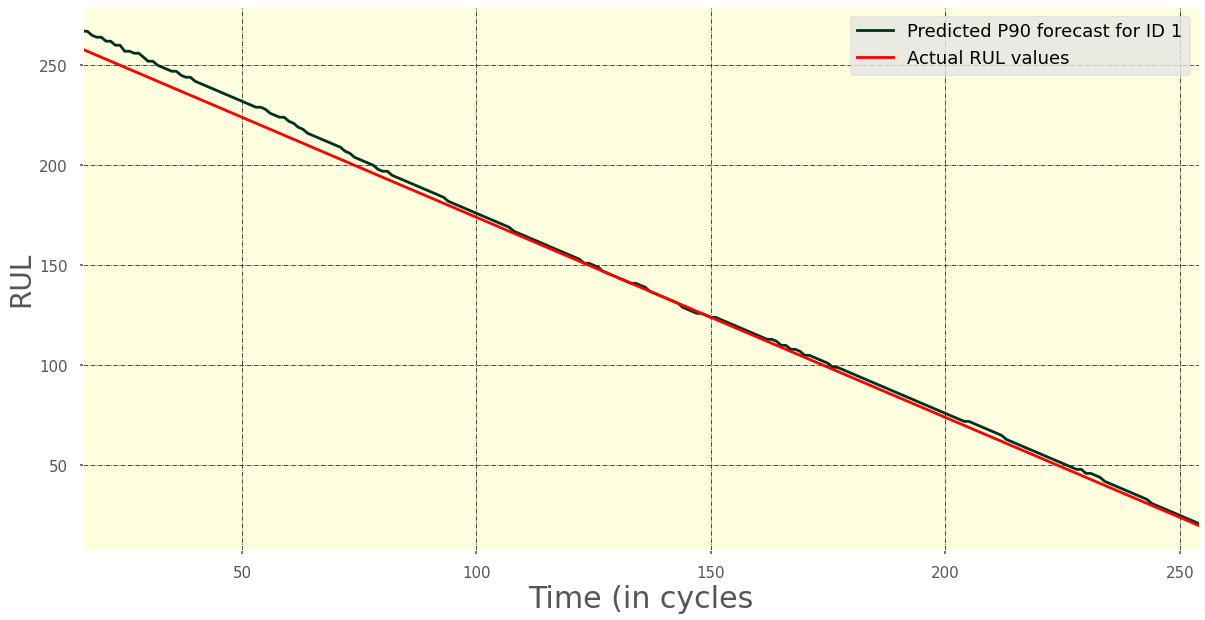

In [ ]:
# Visualising P90 forecasts

unit = 1
import matplotlib.style as style 
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(	'#FFFFE0')
plt.plot(p90_forecast[p90_forecast['identifier']==unit].index, p90_forecast[p90_forecast['identifier']==unit]['t+0'] ,color = '#013220', label="Predicted P90 forecast for ID "+str(unit))
plt.plot(targets[targets['identifier']==unit].index, targets[targets['identifier']==unit]['t+0'], 'r', label="Actual RUL values")
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel('Time (in cycles', size = 30)
plt.ylabel('RUL', size = 28 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 18) 
ax.set_xlim([targets[targets['identifier']==unit].index.min(), targets[targets['identifier']==unit].index.max()])

plt.grid(color='black', linestyle='-.', linewidth=0.7)
plt.savefig('p90_forecast.png',dpi=300)
files.download("p90_forecast.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

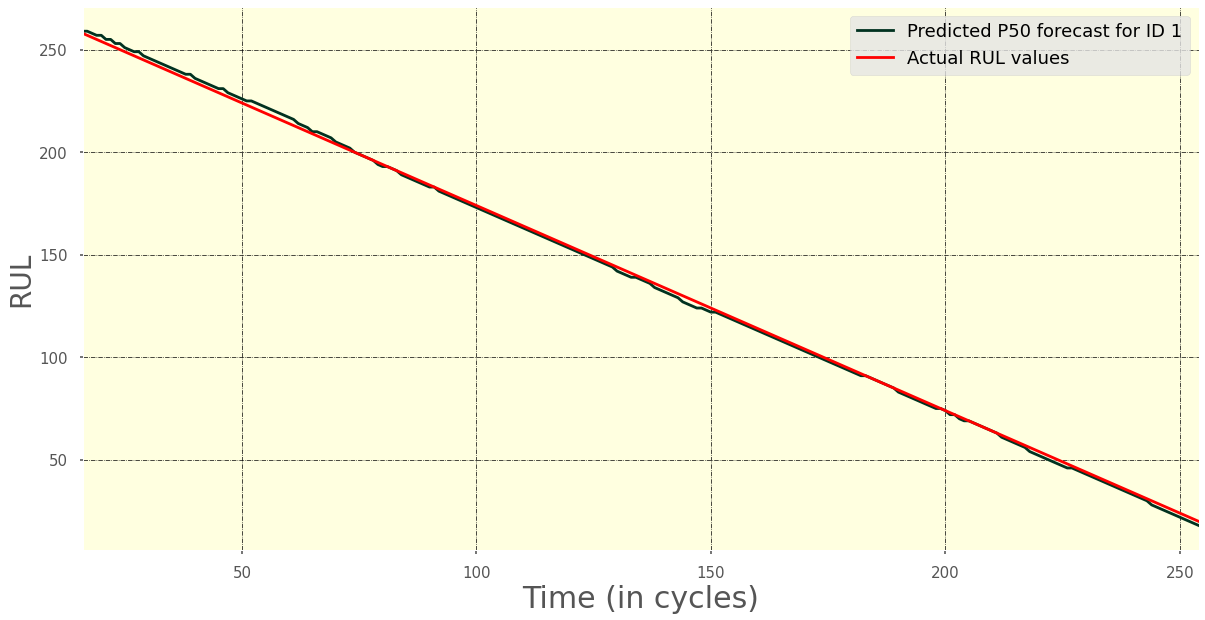

In [ ]:
#Visualising P50 forecasts

unit = 1
import matplotlib.style as style 
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
ax.set_facecolor(	'#FFFFE0')
plt.plot(p50_forecast[p50_forecast['identifier']==unit].index, p50_forecast[p50_forecast['identifier']==unit]['t+0'] ,color = '#013220', label="Predicted P50 forecast for ID "+str(unit))
plt.plot(targets[targets['identifier']==unit].index, targets[targets['identifier']==unit]['t+0'], 'r', label="Actual RUL values")
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel('Time (in cycles)', size = 30)
plt.ylabel('RUL', size = 28 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 18) 
ax.set_xlim([targets[targets['identifier']==unit].index.min(), targets[targets['identifier']==unit].index.max()])

plt.grid(color='black', linestyle='-.', linewidth=0.7)
plt.savefig('p50_forecast.png',dpi=300)
files.download("p50_forecast.png")

In [ ]:
def pltu(x):
    plt.figure(figsize=(20,8))
    plt.plot(df_test[df_test['ID']==1][17:256]['RUL'],df_test[df_test['ID']==1][17:256][x], label = 'Real RUL')
    plt.plot(p50_forecast[p50_forecast['identifier']==1]['t+0'],df_test[df_test['ID']==1][17:256][x], label = 'Predicted RUL')
    plt.ylabel(x)
    plt.xlabel('RUL')
    plt.title(x +' vs RUL')
    plt.legend(loc='best')
    plt.show()
    #plt.savefig('COMP.png')
    #files.download("COMP.png")

for i in ['Setting1','Setting2','Setting3','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10','Sensor11','Sensor12','Sensor13','Sensor14','Sensor15','Sensor16','Sensor17','Sensor18','Sensor19','Sensor20','Sensor21']:
  pltu(i)

Output hidden; open in https://colab.research.google.com to view.